In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm


# Task 1. Explore the data

In [2]:
df = pd.read_csv("/content/student-por.csv", sep=';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [4]:
#Recode the Target Variable

def recode_g3(g):
    if g <= 9:
        return "Low"
    elif g <= 14:
        return "Medium"
    else:
        return "High"

df['G3_cat'] = df['G3'].apply(recode_g3)


In [5]:
# number of observations in each class (Low, Medium, High)
print(df['G3_cat'].value_counts())

G3_cat
Medium    418
High      131
Low       100
Name: count, dtype: int64


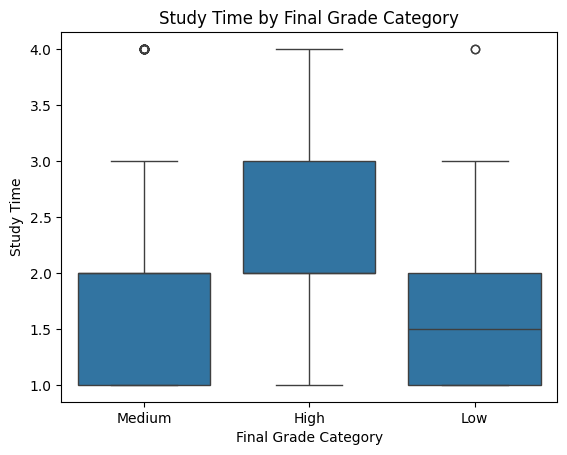

In [6]:
#plot to compare a numeric predictor

sns.boxplot(x='G3_cat', y='studytime', data=df)
plt.title("Study Time by Final Grade Category")
plt.xlabel("Final Grade Category")
plt.ylabel("Study Time")
plt.show()

# Task 2. Fit the multinomial logistic regression model

In [7]:
predictors = ['studytime', 'failures', 'absences', 'Medu']  # you can change these
X = df[predictors]
y = df['G3_cat']

In [12]:
#Encode Target for Modeling

y_encoded = LabelEncoder().fit_transform(y)  # Low=0, Medium=1, High=2
X = sm.add_constant(X)  # add intercept
model = sm.MNLogit(y_encoded, X)
result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.793317
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  649
Model:                        MNLogit   Df Residuals:                      639
Method:                           MLE   Df Model:                            8
Date:                Tue, 13 May 2025   Pseudo R-squ.:                  0.1132
Time:                        05:14:23   Log-Likelihood:                -514.86
converged:                       True   LL-Null:                       -580.56
Covariance Type:            nonrobust   LLR p-value:                 1.458e-24
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9522      0.540      3.617      0.000       0.894       3.010
studytime     -0.7766      0.

# Task 3. Interpret one coefficient

For y=2 (High vs. Low):

Coefficient for studytime = -0.3697

p-value = 0.002

For the High performance group, the coefficient for study time is -0.3697, which means that students who study more are slightly less likely to be in the High group compared to the Low group. This might be because strong students need less study time, or weaker students study more but still struggle.

# Task 4. Evaluate model accuracy

In [9]:
#Train-Test Split and Prediction

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

model = sm.MNLogit(y_train, X_train)
result = model.fit()

y_pred_prob = result.predict(X_test)
y_pred = y_pred_prob.idxmax(axis=1)


Optimization terminated successfully.
         Current function value: 0.787976
         Iterations 8


In [10]:
# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


Confusion Matrix:
[[ 1  0 31]
 [ 0  3 12]
 [ 1  2 80]]

Accuracy Score:
0.6461538461538462


#  Task 5. Write a short summary

In this project, we used a multinomial logistic regression model to predict how well students perform by grouping their final grades into three categories: Low, Medium, and High. We based our predictions on factors like how much time they spent studying, how many times they had failed before, how often they were absent, and their mother's education level. The results showed that study time and past failures had a noticeable impact on performance.

# ROC and AUC

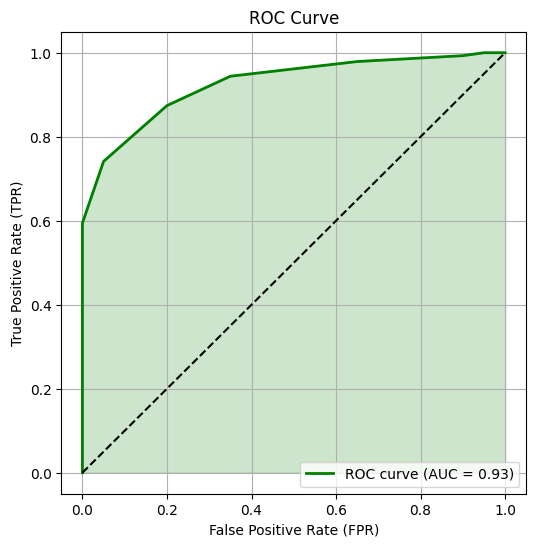

In [17]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_scores = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.fill_between(fpr, tpr, alpha=0.2, color='green')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


1. ROC Curve Shape
The green curve (ROC) indicates high sensitivity (True Positive Rate) and low (False Positive Rate).

2. AUC Value (Area Under Curve)
AUC = 0.93
model is performing very well using only G1 (the student's score in the first term) as a predictor.